# Project 4 : West-Nile-Virus-Prediction

### Contents:
- [Data Preparation](#Data-Preparation)
- [Modelling](#Modelling)
- [Model Evaluation](#Model-Evaluation)
- [Submission](#Submission)

# Import Libraries

In [1]:
# Imports:
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
pd.options.mode.chained_assignment = None 

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler,RobustScaler
from sklearn.inspection import partial_dependence,PartialDependenceDisplay
from sklearn import metrics
from sklearn.metrics import f1_score,confusion_matrix, plot_confusion_matrix,ConfusionMatrixDisplay,accuracy_score, \
RocCurveDisplay, roc_auc_score, PrecisionRecallDisplay
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.dummy import DummyClassifier

from imblearn.pipeline import Pipeline 
from imblearn.over_sampling import RandomOverSampler,SMOTE
from imblearn.under_sampling import RandomUnderSampler 


import lightgbm as lgb

import pickle

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning) 

get_ipython().run_line_magic('matplotlib', 'inline')

pd.options.display.max_columns = None
pd.options.display.max_rows = None


import datetime

In [2]:
#!pip install imblearn

In [3]:
#!pip install lightgbm

# define some functions

In [4]:
#The function will:
# 1. run the input GridSearchCV
# 2. compute and compare the roc_auc_score, F1 score for training data and testing data
# 3. get and print the confusion matrix
# 4. plot the confusion matrix and P-R curve
# 5. plot feature importance list

def run_model(gs, model_name, X_train, y_train, X_test, y_test):
    
    # run the input GridSearchCV
    gs.fit(X_train, y_train)
    
    # print(gs.best_params_)
    if isinstance(gs,GridSearchCV):
        print("best_params: ")
        for (item, value) in gs.best_params_.items():
            print('   ',item, ' : ', value)
    
    #compute and compare the auc_score for training data and testing data
    train_auc_score = gs.score(X_train, y_train)
    test_auc_score = gs.score(X_test, y_test)
    auc_perc_diff = np.abs(test_auc_score/train_auc_score*100-100)
    
    print(f'\nprecision_recall_auc_score on training set: {train_auc_score:.3f}')
    print(f'precision_recall_auc_score on testing set: {test_auc_score:.3f}')
    print(f'perc_diff: {auc_perc_diff:.1f} %\n')
    
    # Get predictions
    y_train_preds = gs.predict(X_train) 
    y_test_preds = gs.predict(X_test)
    
    #calculate the F1_score
    train_f1_score =  f1_score(y_train, y_train_preds)
    test_f1_score = f1_score(y_test, y_test_preds)
    f1_perc_diff = np.abs(test_f1_score/train_f1_score*100-100)
    print(f'\nf1_score on training set: {train_f1_score:.3f}')
    print(f'f1_score on testing set: {test_f1_score:.3f}')
    print(f'perc_diff: {f1_perc_diff:.1f} %\n')
    
    
    
    # Save confusion matrix values
    print("confusion matrix: ")
    cm = confusion_matrix(y_test, y_test_preds)
    cm_df = pd.DataFrame(cm, columns=['pred No virus', 'pred WnvPresent'], 
                         index=['actual No virus', 'actual WnvPresent'])
    print(cm_df.head())
                    
        
    print("\nplot confusion matrix and ROC curve")
    fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=[15,6])
    
    font = {'weight' : 'bold',
            'size'   : 16}
    plt.rc('font', **font)
    
    # View confusion matrix
    ConfusionMatrixDisplay.from_estimator(gs, X_test, y_test, ax=ax1)
    ax1.set_title("confusion matrix")
    
    #plot Precision-Recall curve
    PrecisionRecallDisplay.from_estimator(gs, X_test, y_test,ax=ax2)
    ax2.set_xticks(np.arange(0, 1, 20))
    ax2.set_title("precision recall curve")
    ax2.legend(loc='upper right', fontsize=14)

    #only plot the important feather list if the model is instance of (gridsearchcv)
    if isinstance(gs,GridSearchCV):
        #plot featureimportances
        model = gs.best_estimator_.named_steps["classifier"]
        importances = model.feature_importances_
        indices = np.argsort(importances)
        fig,ax=plt.subplots(1,figsize=(10,24))
        features = X_train.columns
        plt.title('Feature Importances')
        ax.barh(range(len(indices)), importances[indices], color='b', align='center')
        plt.yticks(range(len(indices)), [features[i] for i in indices])
        plt.xlabel('Relative Importance')
        plt.show()
    
    
    return pd.DataFrame({'Precision_Recall__Auc_Train':train_auc_score,
                         'Precision_Recall_Auc_Test':test_auc_score,
                         'Precision_Recall_Auc Generalization %' : auc_perc_diff,
                         
                         'F1_train' : train_f1_score,
                         'F1_test' : test_f1_score,
                         'F1 Generalization %' : f1_perc_diff
                        }, index=[model_name])


# import data from pickle file

In [5]:
#read pickle_dict, which store everything
pickle_dict2 = pickle.load(open('../assets/data2.pkl', 'rb'))
#df_train = pickle_dict2['df_train']
df_test = pickle_dict2['df_test']
df_final = pickle_dict2['df_final']
df_final_submission = pickle_dict2['df_final_submission']


# Data Preparation

In [6]:
#15, smlgb(public Score: 0.74001), oulgb(Public score: 0.75782)
random_key=15

columns_to_drop = ['Date', 'Address', 'Block', 'Street', 'Trap', 'AddressNumberAndStreet', 
                            'Latitude', 'Longitude', 'AddressAccuracy', 'NumMosquitos', 'WnvPresent', 'geometry','Station']

X = df_final.drop(columns=columns_to_drop)
y = df_final['WnvPresent']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=random_key, stratify=y)

#for test submission
columns_to_drop_submission = ['Date', 'Address', 'Block', 'Street', 'Trap', 'AddressNumberAndStreet', 
                            'Latitude', 'Longitude', 'AddressAccuracy', 'geometry','Station', 'Id']

X_submission =  df_final_submission.drop(columns=columns_to_drop_submission)

#result_list to hold the result from each model for final evaluation
result_list = []

In [7]:
# Check what we need to check in a classification problem.
y.value_counts(normalize = True)

0   0.95
1   0.05
Name: WnvPresent, dtype: float64

In [8]:
print("5% of train data are positive, i.e., 'WnvPresent' equal to 1")

5% of train data are positive, i.e., 'WnvPresent' equal to 1


# Metrics
Since train data is highly imbalance, the following metrics will be used:
   - precision_recall_auc_score
   - F1 score

# Modelling
- oversampling and undersampling, or SMOTE
- run model
- evaluate performance

### Baseline Model: DummyClassifier always predicting 'WnvPresent' equal to 1


precision_recall_auc_score on training set: 0.052
precision_recall_auc_score on testing set: 0.052
perc_diff: 0.3 %


f1_score on training set: 0.100
f1_score on testing set: 0.099
perc_diff: 0.3 %

confusion matrix: 
                   pred No virus  pred WnvPresent
actual No virus                0             2987
actual WnvPresent              0              165

plot confusion matrix and ROC curve


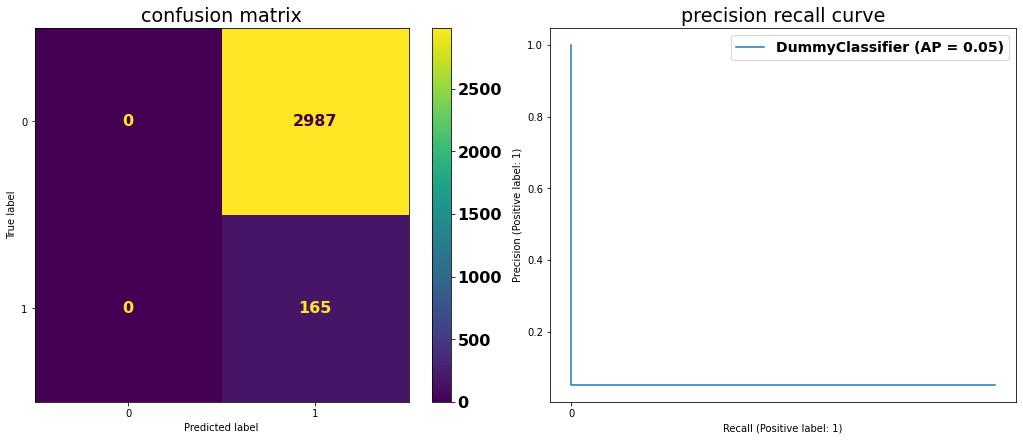

In [9]:
dummy_clf = DummyClassifier(strategy='constant', constant=1)

#finding the best hypermeter list for the model
result = run_model(dummy_clf, "baseline model", X_train, y_train, X_test, y_test )
result_list.append(result)

### Model: OverSampling + UnderSampling + GradientBoostingClassifier

In [10]:
# define pipeline
over = RandomOverSampler(sampling_strategy=0.1, random_state=random_key)
under = RandomUnderSampler(sampling_strategy=0.5, random_state=random_key)
model = GradientBoostingClassifier(random_state=random_key)

steps = [('o', over), ('u', under), ('classifier', model)]
pipe = Pipeline(steps=steps)


#pipeline parameters
pipe_params = {'classifier__n_estimators' : [300,500],       #The number of trees in the forest.
               'classifier__max_depth' : [2,3,4],              #The maximum depth of the tree.
               }

# Instantiate GridSearchCV.
#tscv = TimeSeriesSplit(n_splits=3)
gs_ougb = GridSearchCV(pipe, # what object are we optimizing?
                    param_grid = pipe_params, # what parameters values are we searching?
                    cv=3, # 3-fold cross-validation.
                    n_jobs=-1, 
                    scoring='average_precision' #'average_precision' = precision_recall_auc_score
                    )


#finding the best hypermeter list for the model
result = run_model(gs_ougb, "OverSampling + UnderSampling + GradientBoost", X_train, y_train, X_test, y_test)
result_list.append(result)


ValueError: 
All the 18 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\finan\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\finan\anaconda3\lib\site-packages\imblearn\pipeline.py", line 268, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\finan\anaconda3\lib\site-packages\imblearn\pipeline.py", line 226, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "C:\Users\finan\anaconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\finan\anaconda3\lib\site-packages\imblearn\pipeline.py", line 394, in _fit_resample_one
    X_res, y_res = sampler.fit_resample(X, y, **fit_params)
  File "C:\Users\finan\anaconda3\lib\site-packages\imblearn\base.py", line 77, in fit_resample
    X, y, binarize_y = self._check_X_y(X, y)
  File "C:\Users\finan\anaconda3\lib\site-packages\imblearn\over_sampling\_random_over_sampler.py", line 150, in _check_X_y
    X, y = self._validate_data(
  File "C:\Users\finan\anaconda3\lib\site-packages\sklearn\base.py", line 596, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "C:\Users\finan\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 1074, in check_X_y
    X = check_array(
  File "C:\Users\finan\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 791, in check_array
    array = array.astype(new_dtype)
  File "C:\Users\finan\anaconda3\lib\site-packages\pandas\core\generic.py", line 5815, in astype
    new_data = self._mgr.astype(dtype=dtype, copy=copy, errors=errors)
  File "C:\Users\finan\anaconda3\lib\site-packages\pandas\core\internals\managers.py", line 418, in astype
    return self.apply("astype", dtype=dtype, copy=copy, errors=errors)
  File "C:\Users\finan\anaconda3\lib\site-packages\pandas\core\internals\managers.py", line 327, in apply
    applied = getattr(b, f)(**kwargs)
  File "C:\Users\finan\anaconda3\lib\site-packages\pandas\core\internals\blocks.py", line 591, in astype
    new_values = astype_array_safe(values, dtype, copy=copy, errors=errors)
  File "C:\Users\finan\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py", line 1309, in astype_array_safe
    new_values = astype_array(values, dtype, copy=copy)
  File "C:\Users\finan\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py", line 1257, in astype_array
    values = astype_nansafe(values, dtype, copy=copy)
  File "C:\Users\finan\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py", line 1095, in astype_nansafe
    result = astype_nansafe(flat, dtype, copy=copy, skipna=skipna)
  File "C:\Users\finan\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py", line 1201, in astype_nansafe
    return arr.astype(dtype, copy=True)
ValueError: could not convert string to float: '2011-09'

--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\finan\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\finan\anaconda3\lib\site-packages\imblearn\pipeline.py", line 268, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\finan\anaconda3\lib\site-packages\imblearn\pipeline.py", line 226, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "C:\Users\finan\anaconda3\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\finan\anaconda3\lib\site-packages\imblearn\pipeline.py", line 394, in _fit_resample_one
    X_res, y_res = sampler.fit_resample(X, y, **fit_params)
  File "C:\Users\finan\anaconda3\lib\site-packages\imblearn\base.py", line 77, in fit_resample
    X, y, binarize_y = self._check_X_y(X, y)
  File "C:\Users\finan\anaconda3\lib\site-packages\imblearn\over_sampling\_random_over_sampler.py", line 150, in _check_X_y
    X, y = self._validate_data(
  File "C:\Users\finan\anaconda3\lib\site-packages\sklearn\base.py", line 596, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "C:\Users\finan\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 1074, in check_X_y
    X = check_array(
  File "C:\Users\finan\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 791, in check_array
    array = array.astype(new_dtype)
  File "C:\Users\finan\anaconda3\lib\site-packages\pandas\core\generic.py", line 5815, in astype
    new_data = self._mgr.astype(dtype=dtype, copy=copy, errors=errors)
  File "C:\Users\finan\anaconda3\lib\site-packages\pandas\core\internals\managers.py", line 418, in astype
    return self.apply("astype", dtype=dtype, copy=copy, errors=errors)
  File "C:\Users\finan\anaconda3\lib\site-packages\pandas\core\internals\managers.py", line 327, in apply
    applied = getattr(b, f)(**kwargs)
  File "C:\Users\finan\anaconda3\lib\site-packages\pandas\core\internals\blocks.py", line 591, in astype
    new_values = astype_array_safe(values, dtype, copy=copy, errors=errors)
  File "C:\Users\finan\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py", line 1309, in astype_array_safe
    new_values = astype_array(values, dtype, copy=copy)
  File "C:\Users\finan\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py", line 1257, in astype_array
    values = astype_nansafe(values, dtype, copy=copy)
  File "C:\Users\finan\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py", line 1095, in astype_nansafe
    result = astype_nansafe(flat, dtype, copy=copy, skipna=skipna)
  File "C:\Users\finan\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py", line 1201, in astype_nansafe
    return arr.astype(dtype, copy=True)
ValueError: could not convert string to float: '2011-07'


In [ ]:
if isinstance(gs_ougb,GridSearchCV):
    print("yes")

### Model: OverSampling + UnderSampling + RandomForestClassifier

In [ ]:
# define pipeline
over = RandomOverSampler(sampling_strategy=0.1, random_state=random_key)
under = RandomUnderSampler(sampling_strategy=0.5, random_state=random_key)
model = RandomForestClassifier(random_state=random_key)

steps = [('o', over), ('u', under), ('classifier', model)]
pipe = Pipeline(steps=steps)


#pipeline parameters
pipe_params = {'classifier__n_estimators' : [300],       #The number of trees in the forest.
                'classifier__max_depth' : [4,5,6],              #The maximum depth of the tree.
                'classifier__class_weight' : [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
               }


# Instantiate GridSearchCV.
#tscv = TimeSeriesSplit(n_splits=3)
gs_ourf = GridSearchCV(pipe, # what object are we optimizing?
                    param_grid = pipe_params, # what parameters values are we searching?
                    cv=3, # 3-fold cross-validation.
                    n_jobs=-1, 
                    scoring='average_precision'  #'average_precision' = precision_recall_auc_score
                    )

#finding the best hypermeter list for the model
result = run_model(gs_ourf, "OverSampling + UnderSampling + RandomForest", X_train, y_train, X_test, y_test )
result_list.append(result)


### Model: OverSampling + UnderSampling + LGBMClassifier

In [ ]:
# define pipeline
over = RandomOverSampler(sampling_strategy=0.1, random_state=random_key)
under = RandomUnderSampler(sampling_strategy=0.5, random_state=random_key)
model = lgb.LGBMClassifier(objective='binary', random_state=random_key)

steps = [('o', over), ('u', under), ('classifier', model)]
pipe = Pipeline(steps=steps)


#pipeline parameters
pipe_params = { 'classifier__num_leaves' : [30,35,40],   #The number of trees in the forest.
                'classifier__learning_rate' : [.01,0.05],   #The number of trees in the forest.
                'classifier__max_depth' : [4,5,6],              #The maximum depth of the tree.
                #'classifier__is_unbalance': ['True'],
                'classifier__metric' : ['auc', 'binary_logloss','average_precision']              #The maximum depth of the tree.
                }

# Instantiate GridSearchCV.
#tscv = TimeSeriesSplit(n_splits=3)
gs_oulgb = GridSearchCV(pipe, # what object are we optimizing?
                    param_grid = pipe_params, # what parameters values are we searching?
                    cv=5, # 3-fold cross-validation.
                    n_jobs=-1, 
                    scoring='average_precision' #'average_precision' = precision_recall_auc_score
                    )

#finding the best hypermeter list for the model
result = run_model(gs_oulgb, "OverSampling + UnderSampling + LightGBM",  X_train, y_train, X_test, y_test )
result_list.append(result)

### Model: Smote + GradientBoostingClassifier

In [ ]:
# define pipeline
#over = RandomOverSampler(sampling_strategy=0.1, random_state=random_key)
#under = RandomUnderSampler(sampling_strategy=0.5, random_state=random_key)
sm = SMOTE(sampling_strategy=0.2, random_state=random_key)
model = GradientBoostingClassifier(random_state=random_key)

#steps = [('o', over), ('u', under), ('classifier', model)]
steps = [('smote', sm),  ('classifier', model)]
pipe = Pipeline(steps=steps)


#pipeline parameters
pipe_params = {'classifier__n_estimators' : [300,500],       #The number of trees in the forest.
               'classifier__max_depth' : [2,3,4],              #The maximum depth of the tree.
               }

# Instantiate GridSearchCV.
#tscv = TimeSeriesSplit(n_splits=3)
gs_smgb = GridSearchCV(pipe, # what object are we optimizing?
                    param_grid = pipe_params, # what parameters values are we searching?
                    cv=3, # 3-fold cross-validation.
                    n_jobs=-1, 
                    scoring='average_precision' #'average_precision' = precision_recall_auc_score
                    )


#finding the best hypermeter list for the model
result = run_model(gs_smgb, "Smote  + GradientBoost", X_train, y_train, X_test, y_test)
result_list.append(result)


### Model:Smote + RandomForestClassifier

In [ ]:
# define pipeline
#over = RandomOverSampler(sampling_strategy=0.1, random_state=random_key)
#under = RandomUnderSampler(sampling_strategy=0.5, random_state=random_key)
sm = SMOTE(sampling_strategy=0.2, random_state=random_key)

model = RandomForestClassifier(random_state=random_key)

#steps = [('o', over), ('u', under), ('classifier', model)]
steps = [('smote', sm),  ('classifier', model)]
pipe = Pipeline(steps=steps)


#pipeline parameters
pipe_params = {'classifier__n_estimators' : [300],       #The number of trees in the forest.
                'classifier__max_depth' : [4,5,6],              #The maximum depth of the tree.
                'classifier__class_weight' : [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
               }


# Instantiate GridSearchCV.
#tscv = TimeSeriesSplit(n_splits=3)
gs_smrf = GridSearchCV(pipe, # what object are we optimizing?
                    param_grid = pipe_params, # what parameters values are we searching?
                    cv=3, # 3-fold cross-validation.
                    n_jobs=-1, 
                    scoring='average_precision'  #'average_precision' = precision_recall_auc_score
                    )

#finding the best hypermeter list for the model
result = run_model(gs_smrf, "Smote + RandomForest", X_train, y_train, X_test, y_test )
result_list.append(result)


### Model: SMOTE + LGBMClassifier 

In [ ]:
# define pipeline
#over = RandomOverSampler(sampling_strategy=0.1, random_state=random_key)
#under = RandomUnderSampler(sampling_strategy=0.5, random_state=random_key)
sm = SMOTE(sampling_strategy=0.2, random_state=random_key)

model = lgb.LGBMClassifier(objective='binary', random_state=random_key)

#steps = [('o', over), ('u', under), ('classifier', model)]
steps = [('smote', sm),  ('classifier', model)]
pipe = Pipeline(steps=steps)


#pipeline parameters
pipe_params = { 'classifier__num_leaves' : [30,35,40],   #The number of trees in the forest.
                'classifier__learning_rate' : [.01,0.05],   #The number of trees in the forest.
                'classifier__max_depth' : [4,5,6],              #The maximum depth of the tree.
               # 'classifier__is_unbalance': ['True','False'],
                'classifier__metric' : ['auc', 'binary_logloss','average_precision']              #The maximum depth of the tree.
                }

# Instantiate GridSearchCV.
#tscv = TimeSeriesSplit(n_splits=3)
gs_smlgb = GridSearchCV(pipe, # what object are we optimizing?
                    param_grid = pipe_params, # what parameters values are we searching?
                    cv=5, # 3-fold cross-validation.
                    n_jobs=-1, 
                    scoring='average_precision' #'average_precision' = precision_recall_auc_score
                    )

#finding the best hypermeter list for the model
result = run_model(gs_smlgb, "Smote + LightGBM",  X_train, y_train, X_test, y_test )
result_list.append(result)

# Model Evaluation

In [ ]:
result_final= pd.concat(result_list,axis=0)
result_final

In [ ]:
# Comparing precision-recall curve
plt.rcParams['figure.figsize'] = (12.0, 10.0)
fig=PrecisionRecallDisplay.from_estimator(dummy_clf, X_test, y_test,name="Baseline Model") 
PrecisionRecallDisplay.from_estimator(gs_ougb, X_test, y_test,name="OverSampling + UnderSampling + GradientBoost",ax = fig.ax_) 
PrecisionRecallDisplay.from_estimator(gs_ourf, X_test, y_test, name='OverSampling + UnderSampling + RandomForest',ax = fig.ax_) 
PrecisionRecallDisplay.from_estimator(gs_oulgb, X_test, y_test, name='OverSampling + UnderSampling + LightGBM',ax = fig.ax_) 
PrecisionRecallDisplay.from_estimator(gs_smgb, X_test, y_test,name="Smote + GradientBoost",ax = fig.ax_) 
PrecisionRecallDisplay.from_estimator(gs_smrf, X_test, y_test, name='Smote + RandomForest',ax = fig.ax_)
PrecisionRecallDisplay.from_estimator(gs_smlgb, X_test, y_test, name='Smote + LightGBM',ax = fig.ax_) 
fig.ax_.legend(loc='upper right', fontsize=14)
fig.ax_.set_yticks(np.arange(0, 1.05, 0.05))
fig.figure_.suptitle("precision-recall curve comparison")
plt.show()

In [ ]:
# Comparing ROC AUC
plt.rcParams['figure.figsize'] = (12.0, 10.0)
#plot ROC curve
fig=RocCurveDisplay.from_estimator(dummy_clf, X_test, y_test,name="Baseline Model") 
RocCurveDisplay.from_estimator(gs_ougb, X_test, y_test,name="OverSampling + UnderSampling + GradientBoost",ax = fig.ax_)
RocCurveDisplay.from_estimator(gs_ourf, X_test, y_test, name='OverSampling + UnderSampling + RandomForest',ax = fig.ax_) 
RocCurveDisplay.from_estimator(gs_oulgb, X_test, y_test, name='OverSampling + UnderSampling + LightGBM',ax = fig.ax_) 
RocCurveDisplay.from_estimator(gs_smgb, X_test, y_test,name="Smote + GradientBoost",ax = fig.ax_) 
RocCurveDisplay.from_estimator(gs_smrf, X_test, y_test, name='Smote + RandomForest',ax = fig.ax_)
RocCurveDisplay.from_estimator(gs_smlgb, X_test, y_test, name='Smote + LightGBM',ax = fig.ax_) 
fig.ax_.legend(loc='lower right', fontsize=14)
fig.figure_.suptitle("ROC curve comparison")
fig.ax_.set_xticks(np.arange(0, 1, 20))
plt.show()

**Observations**
- all models actually can not predict well in term of PR-curve and F1 scores
- `Model: SMOTE + LGBMClassifier` will be chosen as production model at this stage as it has the best score and generalization
- Feature Importance: mosquito species and weather conditions are the most important features, while some trap locations provided some mild contributions.

**Future Improvement Plan**
- To add more weather features from the weather data sets
- To try more different lagged days
- To try more different algorithms such as CatBoost, XGBoost
- To try ensemble algorithms.

# Submission

In [ ]:
WnvPresent_prob_list = gs_oulgb.predict_proba(X_submission)
df_test['WnvPresent'] = [list(t) for t in zip(*WnvPresent_prob_list)][1]
df_submission=df_test[['Id','WnvPresent']]
df_submission.to_csv("../assets/submission.csv",index=False)
sns.histplot(df_submission['WnvPresent'])

In [ ]:
p=0.05
r=1
f1 = 2*(p*r)/(p+r)
print(f1)